In [1]:
# ignore warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
#import re
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

### Moore’s law

Use the link here to download a large amount of data relating to CPU specs. The script might take as long as an hour, depending on your connection speed.

In [2]:
# load and observe the benchmark dataset
benchmark = pd.read_csv("benchmarks.csv")
benchmark.head()

,testID,benchName,base,peak
0,cpu95-19990104-03254,101.tomcatv,19.40,27.1
1,cpu95-19990104-03254,102.swim,27.20,34.8
2,cpu95-19990104-03254,103.su2cor,10.10,9.98
3,cpu95-19990104-03254,104.hydro2d,8.58,8.61
4,cpu95-19990104-03254,107.mgrid,8.94,9.44


In [3]:
benchmark.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136995 entries, 0 to 136994
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   testID     136995 non-null  object 
 1   benchName  136995 non-null  object 
 2   base       136995 non-null  float64
 3   peak       131575 non-null  object 
dtypes: float64(1), object(3)
memory usage: 4.2+ MB


Observing the dataset, we see that the first three columns are free of null data, but for column peak there are null data. Therefore, when taking peak speed into account, we need to get rid of rows that contain nulls.

In [4]:
# load and observe the summary data
summary = pd.read_csv("summaries.csv")
summary.head()

,testID,tester,machine,cpu,mhz,hwAvail,os,compiler,autoParallel,benchType,base,peak
0,cpu95-19990104-03254,Dell,Precision WorkStation 610 (450MHz),450 MHz Pentium II XEON,450.0,Jan-1999,Microsoft Windows NT 4.0 sp3,Intel Fortran Compiler 2.4,No,CFP95,13.9,15.2
1,cpu95-19990104-03256,Dell,Precision WorkStation 610 (450MHz),450 MHz Pentium II XEON,450.0,Jan-1999,Microsoft Windows NT 4.0 sp3,"Intel C Compiler 2.4 for Windows NT, Microsoft...",No,CINT95,19.0,19.0
2,cpu95-19990118-03257,"Siemens, Germany",CELSIUS 2000,Pentium II Xeon Processor 450 MHz,450.0,Nov-1998,Windows NT V4.0 (Service Pack 3),Intel C Compiler Plug-In 2.4,No,CINT95,18.9,18.9
3,cpu95-19990118-03258,"Siemens, Germany",CELSIUS 2000,Pentium II Xeon Processor 450 MHz,450.0,Nov-1998,Windows NT V4.0 (Service Pack 4),Intel Fortran Compiler Plug-In 2.4,No,CFP95,13.5,15.0
4,cpu95-19990122-03268,"Sun, Palo Alto",Sun Enterprise 3500,400MHz UltraSPARC II,400.0,Dec-1998,Solaris 2.7,Sun C 5.0,No,CINT95,14.3,17.7


In [5]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10155 entries, 0 to 10154
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   testID        10155 non-null  object 
 1   tester        10155 non-null  object 
 2   machine       8982 non-null   object 
 3   cpu           10155 non-null  object 
 4   mhz           10155 non-null  float64
 5   hwAvail       10155 non-null  object 
 6   os            10155 non-null  object 
 7   compiler      10155 non-null  object 
 8   autoParallel  10155 non-null  object 
 9   benchType     10155 non-null  object 
 10  base          10155 non-null  float64
 11  peak          10155 non-null  object 
dtypes: float64(2), object(10)
memory usage: 952.2+ KB


1. Extract the date and base speed for a benchmark of your choice. Note that the dates contained as part of the testID don't tell us about when the hardware was actually designed, so the test could have been run at a much later date using older hardware. We therefore need the date indicating when the hardware was first available (hwAvail) from the summaries file to really test Moore's Law.

In [6]:
#extract date from benchmark hwAwail
#suppose the cpu is available on the first day of the month
sample_date = datetime.strptime(summary['hwAvail'][0],'%b-%Y') 
print(sample_date)

1999-01-01 00:00:00


In [7]:
#map the date from summary to benchmark on testID
#summary[summary['testID'] == benchmark['testID']]
summary['hwAvail_transform'] = summary['hwAvail'].apply(lambda x: datetime.strptime(x,'%b-%Y'))
summary_extract = summary[['testID','hwAvail_transform']]
summary_extract.head()

,testID,hwAvail_transform
0,cpu95-19990104-03254,1999-01-01
1,cpu95-19990104-03256,1999-01-01
2,cpu95-19990118-03257,1998-11-01
3,cpu95-19990118-03258,1998-11-01
4,cpu95-19990122-03268,1998-12-01


In [8]:
# left join the two dataframes on testID to get the actual available date
merged_left = pd.merge(left=benchmark, right=summary_extract, how='left', left_on='testID', right_on='testID')
merged_left.head()

,testID,benchName,base,peak,hwAvail_transform
0,cpu95-19990104-03254,101.tomcatv,19.40,27.1,1999-01-01
1,cpu95-19990104-03254,102.swim,27.20,34.8,1999-01-01
2,cpu95-19990104-03254,103.su2cor,10.10,9.98,1999-01-01
3,cpu95-19990104-03254,104.hydro2d,8.58,8.61,1999-01-01
4,cpu95-19990104-03254,107.mgrid,8.94,9.44,1999-01-01


In [9]:
# convert time series to time deltas to make it comparable
first_date = merged_left['hwAvail_transform'].min()
merged_left['time_delta'] = merged_left['hwAvail_transform'].apply(lambda x:(x - first_date).total_seconds() / 3600*24)
merged_left = merged_left[merged_left['benchName']=='482.sphinx3']
merged_left.head()

,testID,benchName,base,peak,hwAvail_transform,time_delta
45856,cpu2006-20060513-00002,482.sphinx3,1.01,NaN,1997-04-01,1280448.0
45897,cpu2006-20060513-00009,482.sphinx3,9.91,9.91,2006-01-01,3121920.0
45926,cpu2006-20060513-00013,482.sphinx3,17.30,NaN,2006-05-01,3191040.0
45943,cpu2006-20060513-00014,482.sphinx3,17.10,NaN,2005-06-01,2998656.0
45984,cpu2006-20060513-00017,482.sphinx3,17.70,18.6,2005-09-01,3051648.0


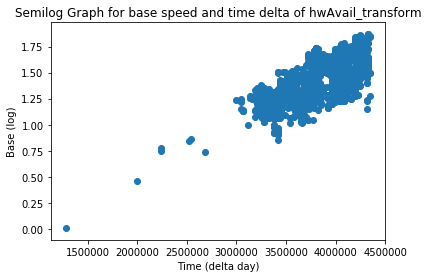

In [10]:
#Plot the data in a semi-log plot (logy) to better show the exponential trend
x = merged_left[['time_delta']]
logy = np.log10(merged_left['base'].values)
plt.scatter(x,logy)
plt.xlabel('Time (delta day)')
plt.ylabel('Base (log)')
plt.title('Semilog Graph for base speed and time delta of hwAvail_transform')

plt.show()

In [11]:
# As we can see from the plot that the log of base speed has a linear relationship with time, 
regr = LinearRegression().fit(x, logy)
pred = regr.predict(x)

Coefficients: 
 [4.47206683e-07]
Intercept: 
 -0.2612910104125101
Mean squared error: 0.02
R-squared: 0.50 , meaning that 50% of the variance in data can be explained by the model.


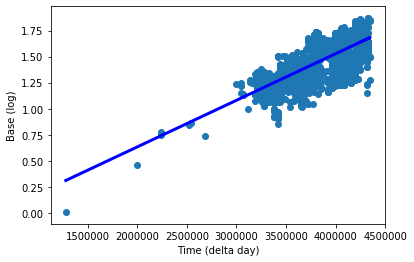

In [12]:
# The coefficient
print('Coefficients: \n', regr.coef_)
# The intercept
print('Intercept: \n', regr.intercept_)
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(logy, pred))
# R-squared: 
print('R-squared: %.2f' % r2_score(logy, pred), ', meaning that 50% of the variance in data can be explained by the model.')

# Plot outputs
plt.scatter(x, logy)
plt.plot(x, pred, color='blue', linewidth=3)
plt.xlabel('Time (delta day)')
plt.ylabel('Base (log)')
plt.show()

How well is Moore’s law holding up?

According to Wikipedia, Moore's law is the observation that the number of transistors in a dense integrated circuit (IC) doubles about every two years. 
The regression model shows that for the selected bench, for every delta day increase in time, the log 10 of the base speed of the cpu increase by 4.47206683e-07, meaning that base speed grows exponentially regarding time, supporting Moore's law.


### MNIST Digits

No machine learning course would be complete without using the MNIST dataset. This dataset was a hugely influential dataset of handwritten digits (0-9).

[http://scikit-learn.org/stable/tutorial/basic/tutorial.html](http://scikit-learn.org/stable/tutorial/basic/tutorial.html)

1. Using Scikit.learn, load the MNIST digits (See here: [http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits)).
2. Plot some of the examples.
3. Choose two digit classes (e.g 7s and 3s) , and train a k-nearest neighbor classifier.
4. Report your error rates on a held out part of the data.
5. (Optional) Test your model on the full dataset (available from [http://yann.lecun.com/exdb/mnist/](http://yann.lecun.com/exdb/mnist/))

In [13]:
# load the MNIST digits
digits = load_digits()

<Figure size 432x288 with 0 Axes>

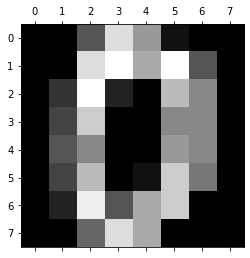

In [14]:
#Plot some of the examples.
plt.gray()
plt.matshow(digits.images[0])
plt.show()

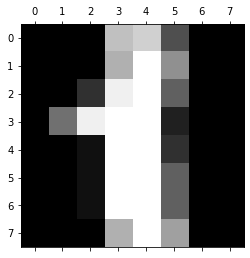

In [15]:
plt.matshow(digits.images[1])
plt.show()

Next, we choose two digit classes (7s and 3s), and train a k-nearest neighbor classifier.

In [16]:
x_digits = digits.data
y_digits = digits.target

def choose_73(x, y):
    x_73 = []
    y_73 = []
    for i in range(len(x)):
        if y[i] == 3 or y[i] == 7:
            x_73.append(x[i])
            y_73.append(y[i])
    return x_73, y_73

x_73, y_73 = choose_73(x_digits,y_digits)

In [17]:
#split into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_73, y_73, test_size=0.2, random_state=123)
print(np.unique(y_train,return_counts=True))
print(np.unique(y_test,return_counts=True))

(array([3, 7]), array([147, 142]))
(array([3, 7]), array([36, 37]))


Cross-validation method is used here to tackle overfitting, by holding out a validation dataset to minimize the error rate for the model chosen.
Also tested values from 3-25 for parameter k to identify the most appropriate one.

In [18]:
#create new a knn model
knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(3, 25, 2)}
#use gridsearch and cross-validation to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv = 5)
#fit model to data
knn_gscv.fit(x_train, y_train)
#get the best choice of k and corresponding training accuracy score
print("The best parameter of k is:", knn_gscv.best_params_)
print("The best accuracy score is:", knn_gscv.best_score_)

The best parameter of k is: {'n_neighbors': 9}
The best accuracy score is: 1.0


After experimentation, the model uses a k value of 9 with a cross-validation accuracy score of 1.0.

In [19]:
#using the test dataset to predict and calculate the error rate
pred = knn_gscv.predict(x_test)
acc = accuracy_score(y_test, pred)
print('The error rate on a held-out dataset is:', 1 - acc, 'the model is doing quite a good job.')

The error rate on a held-out dataset is: 0.013698630136986356 the model is doing quite a good job.


Test on the full dataset: 

In [20]:
#load and transform data
import struct

def load_images(images_file):
    
    with open(images_file,'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        x_n = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        x_n = x_n.reshape((size, nrows, ncols))

    x_n = x_n.reshape(x_n.shape[0], -1).astype('float32')
    
    return x_n

x_train_n = load_images('train-images-idx3-ubyte')
x_test_n = load_images('t10k-images-idx3-ubyte')

In [21]:
def load_labels(labels_file):
    
    with open(labels_file,'rb') as f:
        nrows, ncols = struct.unpack('>II', f.read(8))
        y_n = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))

    return y_n

y_train_n = load_labels('train-labels-idx1-ubyte')
y_test_n = load_labels('t10k-labels-idx1-ubyte')

In [22]:
# choose labels of 7s and 3s
x_73_train_n, y_73_train_n = choose_73(x_train_n, y_train_n)
x_73_test_n, y_73_test_n = choose_73(x_test_n, y_test_n)

In [23]:
# My computer failed to run for different values of k, a default value of 5 is used here
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(x_73_train_n, y_73_train_n)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [24]:
# evaluate the model
pred = neigh.predict(x_73_test_n)
acc = accuracy_score(y_73_test_n, pred)
print('The error rate on a test dataset is:', 1 - acc)

The error rate on a test dataset is: 0.006378802747791901


In [25]:
'''
neigh = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(3, 25, 2)}
#use gridsearch and cross-validation to test all values for n_neighbors
knn_gscv = GridSearchCV(neigh, param_grid, cv = 5)
#fit model to data
knn_gscv.fit(x_73_train_n, y_73_train_n)
#get the best choice of k and corresponding training accuracy score
print("The best parameter of k is:", knn_gscv.best_params_)
print("The best accuracy score is:", knn_gscv.best_score_)
'''

The best parameter of k is: {'n_neighbors': 3}
The best accuracy score is: 0.9948370442078089
